In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import tensorflow as tf
import tensorflow_probability as tfp
from numba import jit

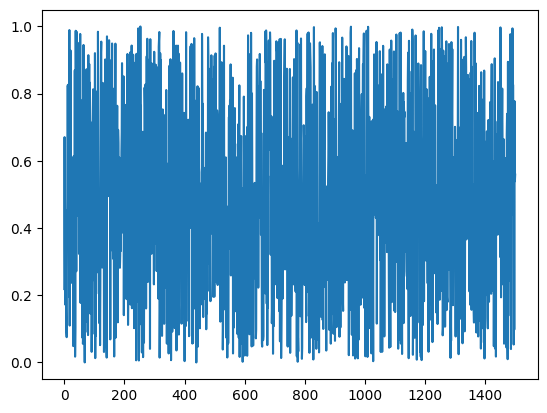

In [24]:
n = 30
p = 50
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
#  we let r=25
r = 10
y = np.zeros(n) #initialising y array
sigmay = 0.01
for i in range(n):
    yTemp = X[i][0:r].sum() + np.random.normal(0, sigmay) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [18]:
def splitGibbs(sigma1, sigma2, sigmay, X, y, niter=1000):
    gamma = 0.1
    rho = 1
    p = len(X[1])
    n = len(X)
    b = p + n
    theta = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
    # for i in range(r): theta[i] = 1                                
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])             #initialising numpy array to store A^t * z and z
    samples = []
    for i in range(b):                                                  #generating A and A^t * A and storing them into numpy array
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            if i == 0:
                Alist = A
                AtA = np.array([np.matmul(A.T, A)])
            else:
                Alist = np.vstack((Alist, A))
                AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

    for t in range(niter):                                              #Beginning of Split Gibbs Sampling
        for i in range(b):
            if i <= p-1:
                sigsig = sigma2 / sigma1
                Aitheta = np.matmul(Alist[i], theta)
                sigmaz = 1 - sigsig**2
                w2 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(sigmaz) * (np.linalg.norm(Aitheta))**2/2)))
                w1 = 1 - w2
                U = np.random.uniform(0,1)
                if U > w2:
                    mu = (sigmaz) * Aitheta
                    z = np.append(z, np.random.normal(mu, sigmaz))
                else:
                    z = np.append(z, 0)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))
            else:
                z = np.append(z, y[i-p] / sigmay)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))

        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
        samples.append(theta.T[0])

    # print("Number of samples is" % str(len(samples)))
    return np.asarray(samples)


# trace = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, X = X, y = y, niter = 100000)

In [21]:
@jit
def compNormal_include(theta_i, gamma, sigma1, sigma2):
    return (gamma * sigma2 * np.exp(-((theta_i**2)/(2*(sigma1**2)))))

@jit
def compNormal_exclude(theta_i, gamma, sigma1, sigma2):
    return ((sigma1-(gamma*sigma1)) * np.exp(-((theta_i**2)/(2*(sigma2**2)))))

@jit
def compNormal_data(theta, y, X, sigmay):
    ssum = 0
    for j in range(len(X)):
        ssum += ((y[j] - np.matmul(X[j], theta))**2)/(2*(sigmay**2))
    return ssum

@jit
def ssp(theta, gamma, X, sigma1, sigma2):
    ssum = 0
    for i in range(len(X[1])):
        ssum += np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2))
        # print(np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2)))
    return ssum

In [19]:
def metroHastings(sigma1, sigma2, sigmay, sigma_theta, X, y, niter = 1000):
    p = len(X[1])
    n = len(X)
    b = p + n
    t = 1
    gamma = 0.1
    no_accept = 0
    theta_0 = np.array([np.zeros(p)]).T                                     #--- initialising theta as zero vectors
    # theta_0 = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1))
    # for i in range(r): theta_0[i] = 1
    thetas = theta_0.T[0]

    while t < niter:
        t += 1
        #symmetric random walk
        theta_c = np.reshape(np.random.multivariate_normal(theta_0.T[0], np.identity(p)*sigma_theta), (-1, 1))
        log_joint_candidate = ssp(theta_c, gamma, X, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
        log_joint_old = ssp(theta_0, gamma, X, sigma1, sigma2) - compNormal_data(theta_0, y, X, sigmay)
        mhr = np.exp(log_joint_candidate - log_joint_old)                   #--- To lessen change of underflows/overflows with MHR
        # print(mhr)
        U = np.random.uniform(0,1)
        if U <= np.minimum(mhr, 1):
            theta_0 = theta_c
            thetas = np.vstack((thetas, theta_c.T[0]))
            no_accept += 1
        else:
            thetas = np.vstack((thetas, theta_0.T[0]))
            # print(thetas)
    
    print("Acceptance Rate is %s, with total number of acceptance of %s" % (str(no_accept/niter), str(no_accept)))
    return thetas


# samples = metroHastings(sigma1 = 1, sigma2 = 0.01, sigmay = 0.01, sigma_theta = 1, X = X, y = y, niter = 50000)
# samples = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, sigma_theta = 1, X = X, y = y, niter = 100000)

tf.Tensor(
[ 0.70927656  0.9361918   0.37046206  0.71772546  0.5155729   0.24345273
  0.75442487  0.59257925  0.98858774  0.5719725  -0.20329389 -0.21275556
 -0.1914373  -0.45609212  0.3001967   0.40414304  0.04472761  0.11742351
  0.16489412  0.0230849   0.28516677 -0.2746965  -0.07770167  0.21022601
  0.23218831  0.0237335   0.0068268  -0.18604484  0.14951135  0.29799017
  0.3081325   0.33637384  0.37468958  0.00521089 -0.12903051 -0.16723746
  0.18762684  0.23309515 -0.15420295 -0.24662378  0.39449668 -0.11857715
  0.09454379 -0.17729083  0.25514856  0.38147202  0.15637825  0.44167313
  0.2830171   0.38723332], shape=(50,), dtype=float32)


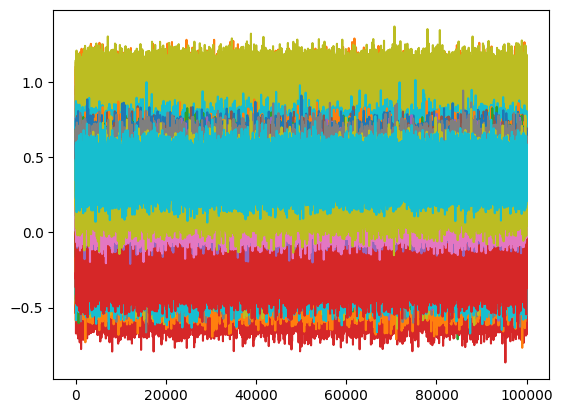

In [26]:
traceSGS = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, X = X, y = y, niter = 100000)

sampleSGS = tf.convert_to_tensor(traceSGS, dtype=tf.float32)
plt.plot(sampleSGS)
meanSGS, varianceSgs = tf.nn.moments(sampleSGS, axes=0)
print(meanSGS)

C:\Users\Johnny Lee\AppData\Local\Temp\ipykernel_29776\2823989320.py:19: RuntimeWarning: overflow encountered in exp
  mhr = np.exp(log_joint_candidate - log_joint_old)                   #--- To lessen change of underflows/overflows with MHR


Acceptance Rate is 0.05926, with total number of acceptance of 2963
tf.Tensor(
[ 7.94600129e-01  9.65541780e-01  2.67244279e-01  8.01829219e-01
  4.67280716e-01  3.37548822e-01  8.66649866e-01  8.06022882e-01
  8.79848301e-01  7.29900777e-01 -1.04361735e-01 -1.00801155e-01
 -4.31157909e-02 -2.94124305e-01  1.75195113e-01  2.94346333e-01
  7.14689195e-02  9.95567217e-02  1.38326764e-01  1.12817392e-01
  3.89076084e-01 -2.21274883e-01  8.35871906e-04  1.02379963e-01
  1.78129420e-01 -7.82437436e-03 -9.10946801e-02 -1.17847301e-01
  2.02290565e-01  1.33578435e-01  2.87088662e-01  5.17414868e-01
  1.24413513e-01 -1.34817779e-01  3.74008529e-02 -1.15634836e-01
  9.15833488e-02 -1.00085912e-02 -1.35244802e-01 -1.85266718e-01
  3.59924376e-01 -7.76425749e-02  5.75113855e-02 -3.59728374e-02
  1.07313670e-01  2.79307872e-01  1.54107943e-01  1.68614820e-01
  2.41764233e-01  2.29361817e-01], shape=(50,), dtype=float32)


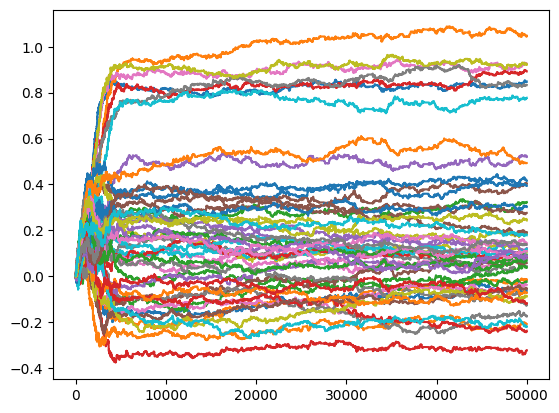

In [28]:
traceMh = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, sigma_theta = 0.00001, X = X, y = y, niter = 50000)
sampleMh = tf.convert_to_tensor(traceMh, dtype = tf.float32)
plt.plot(sampleMh)
# mean-mh, variance = tf.nn.moments(trace, axes=0)
meanMh = tf.math.reduce_mean(sampleMh, axis=0)
print(meanMh)